In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
with open('bgg_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,0.0,3,0,0,0,102580,0.50000,0,0.00,0.0000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,0.0,25,1,0,0,102595,1.29363,0,0.00,-0.3400
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,0.0,28,1,2,15,102597,1.74950,4,2.75,0.9983
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,0.0,25,2,0,1,102598,1.36677,0,0.00,0.4939
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,0.0,7,0,0,1,102599,1.00000,0,0.00,0.0000


In [6]:
df.shape

(100088, 29)

In [29]:
df.columns

Index(['name', 'desc', 'yr_pub', 'min_players', 'max_players', 'avg_play_time',
       'min_play_time', 'max_play_time', 'min_age', 'categories', 'mechanics',
       'families', 'has_expansion', 'designers', 'artists', 'publishers',
       'comments', 'bgtype', 'num_users_rated', 'avg_user_rating',
       'bgg_adj_rating', 'owned', 'trading', 'wanting', 'wishing', 'game_id',
       'stddev', 'num_users_complexity', 'complexity', 'avg_sentiment_score'],
      dtype='object')

In [6]:
#drop, description isn't scraped when run in batches
df[df['desc'].isna()]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,5.50000,0.0,3,0,0,0,102580,0.500000,0,0.00
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,5.42857,0.0,25,1,0,0,102595,1.293630,0,0.00
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,7.54167,0.0,28,1,2,15,102597,1.749500,4,2.75
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,5.08333,0.0,25,2,0,1,102598,1.366770,0,0.00
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,4.00000,0.0,7,0,0,1,102599,1.000000,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100083,All My Ducks,None,1997.0,2,4,5,5,5,6,"[Animals, Children's Game, Memory]",...,5.00000,0.0,6,1,0,1,15346,0.816497,0,0.00
100084,Frosty The Snowman,None,1979.0,2,4,20,20,20,4,"[Children's Game, Movies / TV / Radio theme, R...",...,4.62500,0.0,8,0,0,0,15347,0.414578,0,0.00
100085,Furby Adventure Game,None,1999.0,2,6,15,15,15,4,[Children's Game],...,3.75000,0.0,10,2,0,1,15348,0.559017,2,3.00
100086,Caboose Dice,None,1974.0,2,2,30,30,30,12,[Trains],...,2.50000,0.0,4,1,1,3,15349,0.000000,0,0.00


In [ ]:
df['yr_pub'] = pd.to_datetime(df['yr_pub'],yearfirst=True).year

In [7]:
df.sort_values('yr_pub',ascending=True)

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
29563,Untold Battle,None,0.0,0,0,0,0,0,0,[],...,3.000,0.0,3,0,0,0,69805,0.00000,0,0.0
25926,Turncoat,None,0.0,1,2,15,15,15,10,[Abstract Strategy],...,4.000,0.0,5,0,0,0,99977,0.00000,0,0.0
69524,Einer freut sich immer,None,0.0,2,4,0,0,0,0,"[Children's Game, Racing]",...,0.000,0.0,2,0,0,0,195110,0.00000,0,0.0
69527,Ecken-Schreck!,None,0.0,2,6,0,0,0,0,"[Children's Game, Racing]",...,0.000,0.0,1,0,0,0,195115,0.00000,0,0.0
8115,Stations,None,0.0,2,6,60,45,60,14,"[Abstract Strategy, Puzzle, Transportation]",...,1.000,0.0,0,0,1,5,270228,0.00000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25275,Rio Grande War,None,2022.0,2,2,0,0,0,0,"[American Civil War, Wargame]",...,0.000,0.0,0,0,1,1,321122,0.00000,0,0.0
76316,Nature,None,2023.0,2,5,60,30,60,10,"[Animals, Card Game, Educational, Environmenta...",...,0.000,0.0,0,0,1,7,330152,0.00000,0,0.0
95691,Dominus,None,2023.0,1,4,30,15,30,8,[Medieval],...,0.000,0.0,1,0,1,12,271081,0.00000,0,0.0
14501,Clash of the Princes,None,NaN,0,0,0,0,0,0,"[Exploration, Fantasy, Fighting]",...,6.600,0.0,52,3,2,4,54165,1.13578,3,2.0


In [8]:
df[df['yr_pub']<=1980]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
5,Strat-O-Matic Baseball,None,1962.0,1,2,45,45,45,11,[Sports],...,7.77929,6.30212,1592,69,41,146,2251,1.741010,99,2.3838
7,Touring,None,1906.0,2,6,30,30,30,8,"[Card Game, Racing, Sports]",...,5.19293,5.45706,815,53,2,22,2253,1.618220,18,1.2222
8,Title Bout,None,1979.0,1,2,45,45,45,12,"[Fighting, Sports]",...,6.73842,5.66025,534,28,18,40,2254,1.791120,39,2.1795
10,The Magnificent Race,None,1975.0,2,4,60,60,60,10,"[Children's Game, Nautical, Racing, Trains, Tr...",...,6.26311,5.59584,516,33,8,42,2256,1.449970,37,1.1622
11,Weekend in Vegas,None,1974.0,2,6,180,180,180,0,"[Bluffing, Card Game, Dice, Racing]",...,5.18182,0.00000,53,13,3,1,2257,1.849730,1,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100060,Astrology: The Game of Prediction,None,1972.0,2,10,0,0,0,10,"[Educational, Party Game]",...,4.33333,0.00000,11,1,3,5,15321,4.027680,1,2.0000
100064,Tip the Scale,None,0.0,2,5,20,20,20,7,"[Card Game, Educational, Humor]",...,4.66667,0.00000,24,1,0,0,15326,1.247220,1,2.0000
100080,Frenzied Finance,None,1905.0,3,6,30,30,30,7,"[Card Game, Economic]",...,0.00000,0.00000,1,0,1,2,15343,0.000000,0,0.0000
100084,Frosty The Snowman,None,1979.0,2,4,20,20,20,4,"[Children's Game, Movies / TV / Radio theme, R...",...,4.62500,0.00000,8,0,0,0,15347,0.414578,0,0.0000


In [7]:
df[df['yr_pub']!=0]['yr_pub'].min()

1680.0

In [8]:
df['yr_pub'].max()

2023.0

In [6]:
df['yr_pub'].fillna(1337,inplace=True)

In [7]:
df['yr_pub'].replace(0,1337,inplace=True)

In [8]:
df[df['yr_pub'].isna()]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score


In [9]:
df[df['yr_pub']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score


In [9]:
#check outliers
df['min_players'].value_counts()

2     72660
1     14046
3      8205
4      2469
0      1837
6       243
5       224
8       219
7        64
10       44
12       22
9        21
15        7
20        5
11        4
13        4
16        4
14        3
40        2
18        1
22        1
24        1
25        1
50        1
Name: min_players, dtype: int64

In [10]:
# 88758 (conv. exclusive), *26855, 26860, 92875* are obscure, keep?,  
# set a cutoff?
df[df['min_players']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
23,Oil Power,None,1982.0,0,0,60,60,60,8,"[Deduction, Exploration, Industry / Manufactur...",...,6.11765,0.0,50,4,9,8,2269,1.770090,2,1.5000
189,Uranium Rush,None,1955.0,0,0,0,0,0,8,"[Economic, Educational, Electronic]",...,4.50000,0.0,6,0,4,3,16053,1.658310,2,1.0000
345,Asiphile,None,2005.0,0,0,0,0,0,0,[Educational],...,0.00000,0.0,0,0,0,0,22458,0.000000,0,0.0000
477,Maktkampen: Ett manipulativt sällskapsspel,None,2014.0,0,0,0,0,0,0,"[Bluffing, Card Game, Party Game]",...,4.50000,0.0,4,1,0,0,280481,1.500000,1,1.0000
659,The Cities Game,None,1970.0,0,0,120,60,120,0,"[City Building, Economic, Political]",...,4.95000,0.0,43,5,5,15,4547,2.350000,3,2.6667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99884,Just Like Mama Used to Say,None,2019.0,0,0,0,0,0,0,"[Card Game, Humor, Party Game]",...,6.00000,0.0,3,0,0,0,309910,0.000000,1,1.0000
99906,"BLT: Baby, Lettuce, and Tomato",None,2000.0,0,0,0,0,0,18,"[Collectible Components, Fantasy, Humor]",...,5.00000,0.0,19,5,0,2,15612,0.000000,0,0.0000
99964,Missionary Conquest,None,0.0,0,0,0,0,0,8,"[Economic, Humor, Religious, Transportation]",...,4.37000,0.0,15,2,0,4,23736,2.291750,3,1.6667
99992,A History of Board-Games Other Than Chess,None,1952.0,0,0,0,0,0,0,[Book],...,8.00000,0.0,18,0,4,9,23012,0.707107,1,3.0000


In [11]:
df.iloc[99884]

name                                           Just Like Mama Used to Say
desc                                                                 None
yr_pub                                                             2019.0
min_players                                                             0
max_players                                                             0
avg_play_time                                                           0
min_play_time                                                           0
max_play_time                                                           0
min_age                                                                 0
categories                                 [Card Game, Humor, Party Game]
mechanics                                 [Hand Management, Player Judge]
families                                                               []
has_expansion                                                           0
designers                             

In [12]:
#check outliers
sorted(df['max_players'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 60,
 61,
 64,
 68,
 69,
 72,
 75,
 76,
 80,
 81,
 88,
 90,
 92,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 112,
 120,
 125,
 127,
 150,
 160,
 163,
 190,
 200,
 250,
 362,
 399,
 400,
 420,
 500,
 600,
 900,
 999,
 1000,
 2000,
 10000,
 11299]

In [13]:
#focus on avg. or min?
df['avg_play_time'].value_counts()

0        22225
30       15846
60       11182
20        9195
45        6992
         ...  
38           1
165          1
10080        1
72000        1
72           1
Name: avg_play_time, Length: 177, dtype: int64

In [14]:
df.sort_values('avg_play_time',ascending=False)

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
15678,Office Space: The Game,None,2020.0,2,10,30000000,30,30000000,16,"[Movies / TV / Radio theme, Party Game]",...,3.90000,0.00000,22,1,0,6,311320,0.000000,0,0.0
15524,Ars Combinatoria,None,2017.0,2,8,1576800,10,1576800,0,"[Card Game, Party Game]",...,6.16667,0.00000,32,4,1,6,234010,0.687184,0,0.0
58568,再会の約束 (Saikai no Yakusoku),None,2017.0,2,4,1576800,157680,1576800,8,"[Card Game, Educational, Party Game]",...,3.00000,0.00000,2,1,0,0,229870,0.000000,0,0.0
64806,Vietnam: 1965-1975,None,2021.0,2,2,525600,4,525600,12,"[Vietnam War, Wargame]",...,10.00000,0.00000,1,0,2,20,332402,0.000000,2,3.5
5849,"Death Ride Kursk: Sud-Front, Russland Staff Li...",None,2018.0,6,20,100000,1000,100000,16,[Wargame],...,0.00000,0.00000,1,0,0,0,331152,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56332,Tic-Tac Bingo Game,None,0.0,2,4,0,0,0,3,"[Abstract Strategy, Children's Game, Dice, Rea...",...,4.00000,0.00000,0,0,0,0,114870,1.000000,0,0.0
56336,The Hobbit: An Unexpected Journey,None,2012.0,2,6,0,0,0,6,"[Fantasy, Movies / TV / Radio theme, Novel-based]",...,2.63181,5.43586,65,5,1,4,135801,1.581000,4,1.0
56337,Lalaloopsy: Tea Party Game,None,2012.0,2,4,0,0,0,5,[],...,7.00000,0.00000,0,0,0,0,135802,3.000000,0,0.0
56341,Don't Get Mad,None,2012.0,2,6,0,0,0,8,"[Party Game, Puzzle, Trivia]",...,5.87500,0.00000,6,3,0,0,135807,0.125000,0,0.0


In [15]:
df['min_play_time'].value_counts()

0        21015
30       17250
20       10616
60        9901
15        9189
         ...  
33           1
225          1
2400         1
10080        1
62           1
Name: min_play_time, Length: 126, dtype: int64

In [16]:
df['max_play_time'].value_counts()

0        22225
30       15846
60       11182
20        9195
45        6992
         ...  
38           1
165          1
10080        1
72000        1
72           1
Name: max_play_time, Length: 177, dtype: int64

In [17]:
#avg. = 9.420796
df['min_age'].value_counts()

0       22062
8       17480
12      15234
10      12582
6        6470
14       4485
7        4351
5        3968
4        3133
13       3011
3        1829
9        1534
18       1207
16        931
15        708
11        385
17        314
2         199
21        132
20         22
1          16
30         10
19          6
36          4
60          3
25          2
45          2
50          2
24          1
2017        1
22          1
40          1
112         1
90          1
Name: min_age, dtype: int64

In [19]:
df[df['min_age']!=0].mean()

desc                            NaN
yr_pub                  1851.255094
min_players                2.028862
max_players                6.411619
avg_play_time            473.850793
min_play_time             45.619037
max_play_time            473.850793
min_age                    9.420796
has_expansion              0.083088
num_users_rated          223.190821
avg_user_rating            4.702506
bgg_adj_rating             1.416223
owned                    377.606490
trading                   11.734230
wanting                   11.580102
wishing                   60.702497
game_id                         inf
stddev                     0.941893
num_users_complexity      13.470766
complexity                 0.903338
avg_sentiment_score        0.437044
dtype: float64

In [18]:
df[df['avg_play_time']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
52,Bulyah,None,2000.0,2,6,0,0,0,0,"[Humor, Party Game]",...,0.00000,0.0,0,0,0,0,23856,0.000000,0,0.0000
53,Epées Royales,None,2006.0,2,2,0,0,0,12,"[Medieval, Wargame]",...,7.22222,0.0,55,0,6,6,23857,1.157370,7,2.1429
54,Batman,None,1976.0,2,4,0,0,0,0,[Comic Book / Strip],...,4.00000,0.0,7,0,0,4,23858,2.943920,0,0.0000
55,"Murder à la carte: Eat, Drink, and Be Married",None,1997.0,6,8,0,0,0,18,"[Deduction, Murder/Mystery, Party Game]",...,0.00000,0.0,26,6,3,2,23859,0.000000,0,0.0000
57,Kort Alfapet,None,1996.0,2,4,0,0,0,0,"[Card Game, Word Game]",...,6.00000,0.0,15,0,2,4,23861,0.866025,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100048,Supporters,None,1990.0,2,2,0,0,0,12,[Sports],...,3.50000,0.0,17,0,0,1,15306,1.500000,0,0.0000
100052,HotFlash! The Menopause Game,None,2003.0,2,8,0,0,0,18,"[Educational, Humor]",...,1.00000,0.0,3,0,1,1,15310,0.000000,0,0.0000
100055,Duckula Card Game,None,1989.0,2,4,0,0,0,0,[Movies / TV / Radio theme],...,5.33333,0.0,4,0,1,2,15314,1.247220,0,0.0000
100060,Astrology: The Game of Prediction,None,1972.0,2,10,0,0,0,10,"[Educational, Party Game]",...,4.33333,0.0,11,1,3,5,15321,4.027680,1,2.0000


In [19]:
df[(df['owned']==0)&(df['trading']==0)&(df['wanting']==0)&(df['wishing']==0)]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
52,Bulyah,None,2000.0,2,6,0,0,0,0,"[Humor, Party Game]",...,0.0,0.0,0,0,0,0,23856,0.0,0,0.0
137,Türkisch für den Urlaub,None,2006.0,2,6,45,45,45,8,"[Educational, Travel, Word Game]",...,0.0,0.0,0,0,0,0,102269,0.0,0,0.0
144,Chessnuts,None,1985.0,4,4,0,0,0,0,[Abstract Strategy],...,0.0,0.0,0,0,0,0,308951,0.0,0,0.0
145,Graffiti,None,1999.0,2,4,20,10,20,0,"[Card Game, Word Game]",...,0.0,0.0,0,0,0,0,308952,0.0,0,0.0
160,Rising Darkness,None,0.0,2,5,120,45,120,10,"[Card Game, Horror]",...,1.0,0.0,0,0,0,0,291812,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99962,Play & Learn the Childcraft Quiz Game,None,1976.0,2,6,60,60,60,0,[Trivia],...,0.0,0.0,0,0,0,0,23734,0.0,0,0.0
99966,Soul Sight CCG,None,2004.0,2,4,45,45,45,8,"[Card Game, Memory]",...,0.0,0.0,0,0,0,0,23738,0.0,0,0.0
99996,Speakeasy Street,None,0.0,20,30,0,0,0,0,"[Deduction, Mafia, Murder/Mystery, Party Game]",...,0.0,0.0,0,0,0,0,23019,0.0,0,0.0
100016,Das große Spiel um 15%,None,1979.0,2,4,0,0,0,0,[Dice],...,2.0,0.0,0,0,0,0,23044,0.0,0,0.0


In [20]:
df[df['game_id']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity


In [21]:
df[df['complexity']>5]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity


In [22]:
df.iloc[100058]

name                                                              Palazzo
desc                                                                 None
yr_pub                                                             2005.0
min_players                                                             2
max_players                                                             4
avg_play_time                                                          60
min_play_time                                                          60
max_play_time                                                          60
min_age                                                                10
categories                                                  [Renaissance]
mechanics               [Auction/Bidding, Hand Management, Set Collect...
families                [Admin: Better Description Needed!, Series: Al...
has_expansion                                                           0
designers                             

In [23]:
df['complexity'].describe()

count    100088.000000
mean          0.836208
std           1.105486
min           0.000000
25%           0.000000
50%           0.000000
75%           1.666700
max           5.000000
Name: complexity, dtype: float64

In [32]:
words = set(nltk.corpus.words.words())
df['eng_comments'] = np.empty((len(df), 0)).tolist()
for idx, commlist in enumerate(df['comments']):
    eng_list = []
    for comment in commlist:
        eng_comment = " ".join(w for w in nltk.wordpunct_tokenize(comment) if w.lower() in words or not w.isalpha())
        eng_list.append(eng_comment)
    df.at[idx,'eng_comments'] = eng_list

In [36]:
df.iloc[1]['comments']

['06.02.04.01',
 '06.02.04.01 identische Neuauflage 2015 ((c)2015 + Art. Nr. Position anders)',
 'Okay with kids\nUnfortunately it uses too many stereotypes.',
 'for Kids between 6 and 13 years',
 'Kinderspiel\n']

In [37]:
df.iloc[1]['eng_comments']

['06 . 02 . 04 . 01',
 '06 . 02 . 04 . 01 2015 (( c ) 2015 + Art . . Position )',
 'with Unfortunately it too many .',
 'for between 6 and 13',
 '']

In [32]:
df['comments']

['I made the PnP from the failed Kickstarter, but haven’t tried it yet.',
 "I really like this game. I played with the designer and another guy. I regret not getting it then. I'll have to track him down again to get a copy.\n",
 "Mostly enjoyed first play. There was a loss of bidding tension in the second half, and an obvious leader once everyone's engines were built.",
 "Tentative rating after one partial play -- this seems like the sort of thing that I'm interested in, but I haven't yet gotten a really good handle on the strategy.",
 'This was great.  I wish it was available.',
 "i've been playing Shawn Storie's self-published version for years now. Quint is a really solid worker placement / engine building game. If you're afraid of dice, don't let that put you off. The dice add fun – they won't wreck your game.",
 'Played via Vassal with the designer...very much enjoyed it. Rating will probably go up as I get more plays in. Solid game.',
 'Kickstarter cancelled.',
 'The game play fi

In [72]:
##with open('bgg_df.pickle', 'wb') as bgg_df_pickle:
##    pickle.dump(df, bgg_df_pickle)

In [71]:
##df['avg_sentiment_score'] = 0.0
##for idx, row in enumerate(df['comments']):
##    analyser = SentimentIntensityAnalyzer()
##    vscore = analyser.polarity_scores(row)
##    comscore = vscore.get('compound')
##    df.at[idx,'avg_sentiment_score'] = float(comscore)

In [36]:
for idx, row in enumerate(df['comments'][:10]):
    analyser = SentimentIntensityAnalyzer()
    vscore = analyser.polarity_scores(row)
    comscore = vscore.get('compound')
    print(comscore)

0.0
-0.34
0.9983
0.4939
0.0
1.0
1.0
0.9996
1.0
0.9991


In [15]:
sent_scores = []
for idx, row in enumerate(df['comments']):
    game_sent = []
    for col in row:
        analyser = SentimentIntensityAnalyzer()
        vscore = analyser.polarity_scores(col)
        comscore = vscore.get('compound')
        game_sent.append(comscore)
    sent_scores.append(game_sent)

In [17]:
##with open('sent_scores_list.pickle', 'wb') as sent_scores_pickle:
##    pickle.dump(sent_scores, sent_scores_pickle)

In [4]:
##with open('sent_scores_list.pickle', 'rb') as f:
##    sent_scores = pickle.load(f)

In [18]:
sent_df = pd.DataFrame(sent_scores)

In [23]:
sent_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0000,0.0000,-0.1280,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.2846,0.3384,0.2732,0.822,0.7783,0.8126,0.8341,-0.25,0.9565,0.3182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
sent_df.shape

(100088, 100)

In [22]:
sent_scores[:5]

[[],
 [0.0, 0.0, -0.128, 0.0, 0.0],
 [-0.2846,
  0.3384,
  0.2732,
  0.822,
  0.7783,
  0.8126,
  0.8341,
  -0.25,
  0.9565,
  0.3182,
  0.7184,
  0.4678],
 [0.4939],
 [0.0]]

In [21]:
len(sent_scores)

100088

In [10]:
avg_sent_score_list = []
for score in sent_scores:
    try:
        avg_sent_score_list.append(sum(score)/len(score))
    except:
        avg_sent_score_list.append(0)

In [5]:
avg_sent_score_list2 = []
for score in sent_scores:
    try:
        avg_sent_score_list2.append(sum(score)/len(score))
    except:
        continue

In [30]:
avg_sent_score_list3 = []
for score in sent_scores:
    try:
        avg_sent_score_list3.append(sum(score)/len(score))
    except:
        avg_sent_score_list3.append(3)

In [8]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,100078,100079,100080,100081,100082,100083,100084,100085,100086,100087
0,[],"[0.0, 0.0, -0.128, 0.0, 0.0]","[-0.2846, 0.3384, 0.2732, 0.822, 0.7783, 0.812...",[0.4939],[0.0],"[0.5719, 0.0, 0.9326, 0.0, 0.9485, 0.6922, 0.0...","[0.0, 0.8268, 0.765, 0.0, 0.0, 0.9366, 0.34, 0...","[0.5267, 0.4939, 0.8464, 0.0, 0.0, 0.0, 0.34, ...","[0.0, 0.3811, 0.0, 0.979, 0.0, 0.0, 0.8225, 0....","[-0.308, 0.0, 0.3182, 0.9269, 0.9705, 0.7964, ...",...,"[0.6597, 0.25, 0.0]","[0.6976, 0.0, 0.765, -0.4939, 0.92, 0.0, -0.36...",[],[],[],[],[0.0],"[-0.4914, 0.5267, 0.8176, 0.7003]","[-0.3054, -0.296]","[0.2244, 0.6369, 0.731, -0.296]"
1,-0.0256,0.482075,0.4939,0.0,0.42612,0.419377,0.204987,0.397472,0.485533,0.442463,...,None,None,None,None,None,None,None,None,None,None


In [11]:
avg_sent_score_list2.value_counts

AttributeError: 'list' object has no attribute 'value_counts'

In [37]:
count = 0
for item in avg_sent_score_list:
    if item == 0:
        count += 1
print(count)

43246


In [7]:
count = 0
for item in avg_sent_score_list2:
    if item == 0:
        count += 1
print(count)

11077


In [59]:
for idx, item in enumerate(sent_scores):
    if len(item) == 100:
        print(idx)

5
6
7
8
10
12
13
19
20
22
26
33
36
38
39
42
44
45
83
93
95
97
101
104
106
107
109
110
113
114
116
117
118
124
127
129
151
183
242
245
292
298
333
344
352
359
366
370
371
383
395
418
455
471
476
482
504
506
507
508
509
510
511
512
513
514
518
521
526
527
528
529
542
547
558
571
590
607
619
636
643
646
662
708
741
747
799
817
820
848
882
887
908
931
932
985
989
990
991
998
1023
1030
1044
1055
1080
1101
1108
1159
1168
1171
1176
1196
1201
1202
1206
1257
1266
1267
1273
1294
1364
1392
1398
1433
1437
1562
1586
1593
1613
1646
1647
1651
1664
1685
1690
1693
1717
1742
1748
1768
1802
1805
1879
1913
1915
1928
1947
1951
1957
1999
2028
2036
2064
2117
2118
2119
2152
2166
2178
2185
2186
2193
2217
2219
2220
2230
2240
2243
2244
2257
2269
2272
2287
2299
2312
2321
2346
2361
2401
2457
2471
2480
2487
2497
2560
2593
2635
2637
2648
2699
2704
2713
2731
2767
2771
2776
2779
2788
2795
2835
2873
2881
2901
2902
2918
2930
2931
2941
2951
2964
2965
2978
3012
3036
3038
3068
3106
3123
3130
3136
3145
3158
3172
3190
3233
3

47711
47712
47716
47720
47723
47744
47769
47770
47793
47806
47843
47856
47857
47929
47936
47938
47942
47973
47999
48004
48020
48021
48024
48030
48032
48033
48044
48062
48099
48147
48164
48205
48317
48319
48369
48380
48383
48409
48447
48450
48458
48499
48578
48595
48596
48610
48640
48646
48713
48718
48720
48723
48735
48736
48751
48755
48777
48779
48787
48798
48830
48862
48901
48914
48932
48951
48957
48971
49003
49033
49034
49091
49125
49155
49183
49184
49188
49193
49224
49231
49243
49267
49285
49296
49297
49298
49308
49312
49322
49324
49327
49343
49349
49385
49431
49433
49434
49442
49471
49475
49484
49485
49488
49494
49495
49566
49577
49628
49640
49655
49669
49686
49687
49688
49691
49710
49727
49730
49733
49738
49744
49757
49766
49783
49787
49799
49810
49830
49841
49842
49896
49898
49914
49925
49957
49983
49984
50003
50031
50080
50162
50175
50201
50210
50225
50256
50269
50311
50317
50354
50360
50375
50403
50421
50433
50439
50499
50503
50512
50513
50520
50521
50579
50580
50585
50587
5060

71047
71056
71065
71072
71073
71131
71133
71149
71150
71198
71240
71253
71254
71259
71290
71295
71300
71315
71326
71329
71359
71364
71386
71395
71401
71422
71423
71473
71474
71475
71502
71503
71506
71515
71519
71523
71525
71531
71547
71572
71629
71646
71718
71719
71749
71774
71779
71781
71785
71811
71854
71869
71872
71876
71883
71895
71898
71925
71939
71951
71953
71954
71955
71997
72011
72014
72021
72026
72091
72131
72141
72164
72176
72181
72204
72218
72222
72240
72243
72247
72271
72272
72281
72324
72332
72386
72419
72425
72442
72451
72473
72486
72504
72530
72543
72563
72568
72609
72633
72669
72684
72700
72705
72726
72740
72741
72756
72757
72793
72794
72797
72824
72835
72865
72928
72942
72943
72948
72950
72965
72967
73000
73018
73020
73046
73084
73093
73096
73111
73120
73182
73185
73208
73215
73216
73221
73229
73242
73249
73267
73279
73288
73293
73294
73298
73347
73348
73389
73390
73393
73414
73416
73430
73431
73433
73434
73446
73454
73479
73502
73513
73516
73517
73570
73613
73620
7362

91640
91682
91688
91746
91776
91807
91823
91824
91839
91872
91873
91880
91888
91890
91899
91902
91906
91907
91908
91920
91930
91933
91940
91987
92004
92061
92065
92069
92093
92113
92124
92125
92127
92152
92178
92179
92225
92241
92246
92264
92279
92294
92333
92340
92383
92441
92469
92481
92496
92518
92550
92551
92574
92579
92601
92625
92657
92658
92676
92727
92729
92733
92758
92798
92806
92824
92833
92838
92843
92856
92857
92863
92870
92873
92911
92916
92921
92923
92940
92951
92965
92991
93014
93043
93061
93079
93083
93085
93086
93090
93107
93113
93115
93116
93117
93123
93125
93126
93153
93159
93161
93186
93239
93241
93248
93270
93282
93307
93314
93324
93330
93331
93394
93426
93427
93437
93455
93485
93502
93576
93584
93590
93643
93646
93654
93668
93674
93675
93676
93680
93681
93682
93688
93689
93691
93693
93696
93697
93698
93699
93704
93711
93713
93714
93717
93725
93730
93731
93733
93735
93736
93737
93749
93752
93757
93764
93771
93823
93824
93833
93846
93869
93907
93928
93944
93946
9398

In [64]:
df.iloc[99991]

name                           Risk: 40th Anniversary Collector's Edition
desc                                                                 None
yr_pub                                                             1999.0
min_players                                                             2
max_players                                                             6
avg_play_time                                                         120
min_play_time                                                         120
max_play_time                                                         120
min_age                                                                 8
categories                                  [Territory Building, Wargame]
mechanics               [Area Majority / Influence, Area Movement, Dic...
families                                                               []
has_expansion                                                           0
designers                            [

In [73]:
avgss.iloc[99991]

avg_sent_score    0.211113
Name: 99991, dtype: float64

In [18]:
avg_sent_df = pd.DataFrame(avg_sent_score_list,columns=['avg_sent_score'])

In [19]:
avg_sent_df.head()

,avg_sent_score
0,0.000000
1,-0.025600
2,0.482075
3,0.493900
4,0.000000


In [20]:
len(avg_sent_df)

100088

In [26]:
len(avg_sent_score_list)

100088

In [64]:
df.at[0,'avg_sentiment_score'] = 1

In [37]:
df['comments'][5]

['Please can I play this game',
 'Thrifted 1990 complet copy 2.99',
 "Classic dice and charts baseball game. I played many games until I started playing the computer version which is great (and better for season replays). It's a religion as much as a game. Catholic or Protestant? APBA or Strat? I probably like APBA a bit better as a system with those magical numbers and I prefer the more standard card size. But Strat-O-Matic *feels* like baseball when you play a single game and there's much less chart referencing than either APBA or Statis Pro. ",
 '2008, 2010, HoF 75',
 "First sports sim I ever played.  Still love it.  I use super advanced rules as they bring a lot of more strategic elements to the game. Still a great game even with all the others on the market.  I don't mind the 50/50 interface.",
 'Not a big sports fan, but a friend in middle school was wildly into this for a bit.  We both purchased copies and my brother used to run whole seasons, as he was a sports statistics nut. 

In [4]:
df['avg_sentiment_score'].value_counts()

 0.0000    44128
 0.9999     4203
 1.0000     2827
 0.9998     1690
 0.9997     1044
           ...  
-0.2341        1
 0.4105        1
 0.3326        1
-0.8541        1
 0.5730        1
Name: avg_sentiment_score, Length: 7738, dtype: int64

In [70]:
df.head()

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,0.0,3,0,0,0,102580,0.50000,0,0.00,0.0000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,0.0,25,1,0,0,102595,1.29363,0,0.00,-0.3400
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,0.0,28,1,2,15,102597,1.74950,4,2.75,0.9983
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,0.0,25,2,0,1,102598,1.36677,0,0.00,0.4939
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,0.0,7,0,0,1,102599,1.00000,0,0.00,0.0000


In [46]:
for comment in df['comments'][:20]:
    analyser = SentimentIntensityAnalyzer()
    vscore = analyser.polarity_scores(comment)
    sentiment = vscore.get('compound')
    print(sentiment)

0.0
-0.34
0.9983
0.4939
0.0
1.0
1.0
0.9996
1.0
0.9991
1.0
0.9758
0.9998
0.9998
0.9563
0.5994
0.9998
0.9971
0.9981
0.9998


In [34]:
score_list = []
for comment in df['comments']:
    analyser = SentimentIntensityAnalyzer()
    vscore = analyser.polarity_scores(df['comments'][2])
    sentiment = vscore.get('compound')
    score_list.append(sentiment)
print(np.mean(score_list))

0.9983000000000001


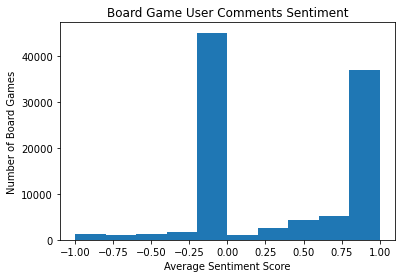

In [8]:
plt.hist(df['avg_sentiment_score'])
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Board Games')
plt.title('Board Game User Comments Sentiment')
plt.savefig('sentiment_hist.svg');

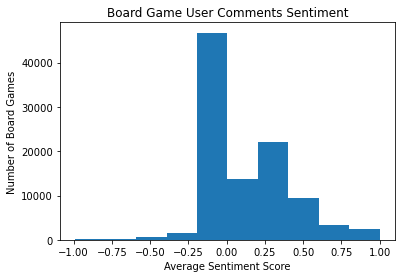

In [27]:
plt.hist(avg_sent_score_list)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Board Games')
plt.title('Board Game User Comments Sentiment');

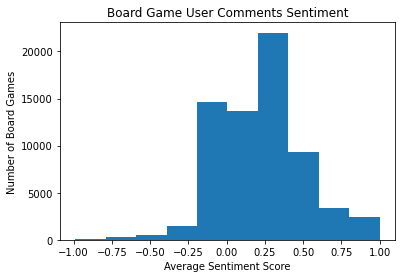

In [6]:
plt.hist(avg_sent_score_list2)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Board Games')
plt.title('Board Game User Comments Sentiment')
plt.savefig('sentiment_hist.svg');

In [31]:
avgss = pd.DataFrame(avg_sent_score_list3,columns=['avg_sent_score'])

In [71]:
avgss[avgss['avg_sent_score']==0]

,avg_sent_score
4,0.0
63,0.0
71,0.0
147,0.0
152,0.0
...,...
100051,0.0
100056,0.0
100066,0.0
100069,0.0


In [40]:
sent_scores[100066]

[0.0]

In [72]:
df.iloc[100084]

name                                                   Frosty The Snowman
desc                                                                 None
yr_pub                                                             1979.0
min_players                                                             2
max_players                                                             4
avg_play_time                                                          20
min_play_time                                                          20
max_play_time                                                          20
min_age                                                                 4
categories              [Children's Game, Movies / TV / Radio theme, R...
mechanics                          [Roll / Spin and Move, Set Collection]
families                                                               []
has_expansion                                                           0
designers                             

In [5]:
df['bgtype'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                             78391
[wargames]                                                      7432
[abstracts]                                                     4240
[childrensgames]                                                3796
[strategygames]                                                 1500
[familygames]                                                   1479
[thematic]                                                       663
[cgs]                                                            443
[partygames]                                                     426
[strategygames, familygames]                                     357
[thematic, strategygames]                                        223
[wargames, thematic]                                             150
[partygames, familygames]                                        141
[abstracts, familygames]                                         124
[thematic, familygames]           

In [10]:
#,'designers','artists','publishers'
cat_columns = ['categories','mechanics','families']
num_columns = ['yr_pub','min_players','max_players','avg_play_time','min_play_time','max_play_time','min_age','complexity']

In [49]:
cat_columns2 = ['categories','mechanics','families']
cat_mlb_list2 = []
class_list2 = []
for col in cat_columns2:
    mlb = MultiLabelBinarizer()
    df_mlb = mlb.fit_transform(df[col])
    mlbdf = pd.DataFrame(df_mlb,columns=mlb.classes_)
    cat_mlb_list2.append(mlbdf)
    class_list2.append(mlb.classes_)

In [11]:
cat_mlb_list = []
class_list = []
for col in cat_columns:
    mlb = MultiLabelBinarizer()
    df_mlb = mlb.fit_transform(df[col])
    mlbdf = pd.DataFrame(df_mlb,columns=mlb.classes_)
    cat_mlb_list.append(mlbdf)
    class_list.append(mlb.classes_)

In [9]:
class_list

[array(['Abstract Strategy', 'Action / Dexterity', 'Adventure',
        'Age of Reason', 'American Civil War', 'American Indian Wars',
        'American Revolutionary War', 'American West', 'Ancient',
        'Animals', 'Arabian', 'Aviation / Flight', 'Bluffing', 'Book',
        'Card Game', "Children's Game", 'City Building', 'Civil War',
        'Civilization', 'Collectible Components', 'Comic Book / Strip',
        'Deduction', 'Dice', 'Economic', 'Educational', 'Electronic',
        'Environmental', 'Expansion for Base-game', 'Exploration',
        'Fan Expansion', 'Fantasy', 'Farming', 'Fighting', 'Game System',
        'Horror', 'Humor', 'Industry / Manufacturing', 'Korean War',
        'Mafia', 'Math', 'Mature / Adult', 'Maze', 'Medical', 'Medieval',
        'Memory', 'Miniatures', 'Modern Warfare',
        'Movies / TV / Radio theme', 'Murder/Mystery', 'Music',
        'Mythology', 'Napoleonic', 'Nautical', 'Negotiation',
        'Novel-based', 'Number', 'Party Game', 'Pike and

In [45]:
for item in class_list:
    print(len(item))

84
182
4143
30911
21047
21672


In [37]:
from sklearn.preprocessing import StandardScaler
num_ss_list = []
for col in num_columns:
    scalar = StandardScaler()
    df_ss = scalar.fit_transform(df[col].values.reshape(-1,1))
    ssdf = pd.DataFrame(df_ss,columns=['scaled_'+str(col)])
    num_ss_list.append(ssdf)

In [20]:
num_ss_list[:6]

[          yr_pub
 0       0.325022
 1       0.331922
 2       0.335372
 3       0.312948
 4       0.331922
 ...          ...
 100083  0.311223
 100084  0.280176
 100085  0.314673
 100086  0.271551
 100087  0.292250
 
 [100088 rows x 1 columns],
         min_players
 0          0.000258
 1          0.000258
 2          0.000258
 3         -1.173922
 4          0.000258
 ...             ...
 100083     0.000258
 100084     0.000258
 100085     0.000258
 100086     0.000258
 100087     0.000258
 
 [100088 rows x 1 columns],
         max_players
 0         -0.083245
 1         -0.044188
 2         -0.024659
 3         -0.024659
 4         -0.044188
 ...             ...
 100083    -0.044188
 100084    -0.044188
 100085    -0.005131
 100086    -0.083245
 100087     0.033927
 
 [100088 rows x 1 columns],
         avg_play_time
 0           -0.003503
 1           -0.003871
 2           -0.003661
 3           -0.003871
 4           -0.003976
 ...               ...
 100083      -0.004081
 10008

In [38]:
num_df = pd.concat(num_ss_list,axis=1)

In [39]:
num_df.head()

,scaled_yr_pub,scaled_min_players,scaled_max_players,scaled_avg_play_time,scaled_min_play_time,scaled_max_play_time,scaled_min_age,scaled_complexity
0,0.335794,0.000258,-0.083245,-0.003503,0.031223,-0.003503,0.081888,-0.756420
1,0.356451,0.000258,-0.044188,-0.003871,-0.029224,-0.003871,-0.167849,-0.756420
2,0.366779,0.000258,-0.024659,-0.003661,0.005317,-0.003661,0.706231,1.731186
3,0.299646,-1.173922,-0.024659,-0.003871,-0.029224,-0.003871,-0.167849,-0.756420
4,0.356451,0.000258,-0.044188,-0.003976,-0.046495,-0.003976,-0.167849,-0.756420


In [18]:
ss = StandardScaler()
testss = ss.fit_transform(df['yr_pub'].values.reshape(-1,1))

In [19]:
testss

array([[0.32505642],
       [0.33195532],
       [0.33540477],
       ...,
       [0.31470806],
       [0.27158993],
       [0.29228664]])

In [29]:
for col in cat_columns:
    print(col)

categories
mechanics
families
designers
artists
publishers


In [29]:
cat_df = pd.concat(np.concatenate(df_list,axis=1))

NameError: name 'df_list' is not defined

In [12]:
cat_df = pd.concat(cat_mlb_list,axis=1)

In [13]:
cat_df.head()

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,...,Video Game Theme: SEGA,Video Game Theme: Sonic the Hedgehog,Video Game Theme: Super Mario Bros.,Video Game Theme: Tetris,Webcomics: Dork Tower,Webcomics: Penny Arcade,Word Games: First Letter Given,Word Games: Guess the Word,Word Games: Sign Language,Word Games: Spelling / Letters
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
for i in range(5):
    print(cat_df.iloc[:,i].sum())

8745
5497
3335
471
768


In [26]:
cat_df['Adventure'].sum()

3335

In [26]:
#details = df[['name','avg_sentiment_score','url']+num_columns]
details = df[['avg_user_rating','has_expansion']]

In [24]:
details.head()

,name,avg_sentiment_score,url,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,complexity
0,Troia,0.0000,https://boardgamegeek.com/boardgame/102580,2005.0,2,2,60,60,60,8,0.00
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,-0.3400,https://boardgamegeek.com/boardgame/102595,2009.0,2,4,25,25,25,6,0.00
2,Quintessential: The Fifth Element,0.9983,https://boardgamegeek.com/boardgame/102597,2011.0,2,5,45,45,45,13,2.75
3,Wort für Wort,0.4939,https://boardgamegeek.com/boardgame/102598,1998.0,1,5,25,25,25,6,0.00
4,Hannah Montana Secret Star,0.0000,https://boardgamegeek.com/boardgame/102599,2009.0,2,4,15,15,15,6,0.00


In [27]:
rec_df = pd.concat([rec_df,details,avg_sent_df],axis=1)

In [6]:
##with open('rec_df.pickle', 'rb') as f:
##    rec_df = pickle.load(f)

In [29]:
##with open('rec_df.pickle', 'wb') as rec_df_pickle:
##    pickle.dump(rec_df, rec_df_pickle)

In [28]:
rec_df.head()

,name,url,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,complexity,...,Video Game Theme: Tetris,Webcomics: Dork Tower,Webcomics: Penny Arcade,Word Games: First Letter Given,Word Games: Guess the Word,Word Games: Sign Language,Word Games: Spelling / Letters,avg_user_rating,has_expansion,avg_sent_score
0,Troia,https://boardgamegeek.com/boardgame/102580,2005.0,2,2,60,60,60,8,0.00,...,0,0,0,0,0,0,0,5.50000,0,0.000000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,https://boardgamegeek.com/boardgame/102595,2009.0,2,4,25,25,25,6,0.00,...,0,0,0,0,0,0,0,5.42857,0,-0.025600
2,Quintessential: The Fifth Element,https://boardgamegeek.com/boardgame/102597,2011.0,2,5,45,45,45,13,2.75,...,0,0,0,0,0,0,0,7.54167,0,0.482075
3,Wort für Wort,https://boardgamegeek.com/boardgame/102598,1998.0,1,5,25,25,25,6,0.00,...,0,0,0,0,0,0,0,5.08333,0,0.493900
4,Hannah Montana Secret Star,https://boardgamegeek.com/boardgame/102599,2009.0,2,4,15,15,15,6,0.00,...,0,0,0,0,0,0,0,4.00000,0,0.000000


In [20]:
start = 'https://boardgamegeek.com/boardgame/'

In [21]:
df['url'] = start + df['game_id']

In [22]:
df['url'].head()

0    https://boardgamegeek.com/boardgame/102580
1    https://boardgamegeek.com/boardgame/102595
2    https://boardgamegeek.com/boardgame/102597
3    https://boardgamegeek.com/boardgame/102598
4    https://boardgamegeek.com/boardgame/102599
Name: url, dtype: object

In [15]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

rec_df.style.format({'url': make_clickable})

ValueError: style is not supported for non-unique indices.

In [9]:
rec_df = pd.concat([rec_df,df['url']],axis=1)

In [23]:
rec_df = rec_df.drop('avg_sentiment_score',axis=1)

In [25]:
rec_df['has_expansion'].head()

KeyError: 'has_expansion'

In [13]:
data = [dict(name='Google', url='http://www.google.com'),
        dict(name='Stackoverflow', url='http://stackoverflow.com')]
testdf = pd.DataFrame(data)

def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

testdf.style.format({'url': make_clickable})

,name,url
0,Google,http://www.google.com
1,Stackoverflow,http://stackoverflow.com


In [22]:
rec_df[rec_df['name'].str.contains('Pandemic')]

,name,avg_sentiment_score,url,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,...,Video Game Theme: SEGA,Video Game Theme: Sonic the Hedgehog,Video Game Theme: Super Mario Bros.,Video Game Theme: Tetris,Webcomics: Dork Tower,Webcomics: Penny Arcade,Word Games: First Letter Given,Word Games: Guess the Word,Word Games: Sign Language,Word Games: Spelling / Letters
1690,Pandemic Legacy: Season 1,1.0000,https://boardgamegeek.com/boardgame/161936,2015.0,2,4,60,60,60,13,...,0,0,0,0,0,0,0,0,0,0
6672,Pandemic: Iberia,1.0000,https://boardgamegeek.com/boardgame/198928,2016.0,2,5,45,45,45,8,...,0,0,0,0,0,0,0,0,0,0
14379,Pandemic: Rapid Response,0.9999,https://boardgamegeek.com/boardgame/280789,2019.0,2,4,20,20,20,8,...,0,0,0,0,0,0,0,0,0,0
18117,Pandemic: Rising Tide,1.0000,https://boardgamegeek.com/boardgame/234671,2017.0,2,5,45,45,45,8,...,0,0,0,0,0,0,0,0,0,0
19298,Pandemic: The Cure,1.0000,https://boardgamegeek.com/boardgame/150658,2014.0,2,5,30,30,30,8,...,0,0,0,0,0,0,0,0,0,0
22045,American Pandemic: The Party Card Game,-0.8541,https://boardgamegeek.com/boardgame/329712,2021.0,2,10,120,30,120,13,...,0,0,0,0,0,0,0,0,0,0
24888,Pandemic: Hot Zone – Europe,0.0000,https://boardgamegeek.com/boardgame/329670,2021.0,2,4,30,30,30,8,...,0,0,0,0,0,0,0,0,0,0
27945,People Vs Pandemic,0.0000,https://boardgamegeek.com/boardgame/324628,2020.0,4,6,150,90,150,7,...,0,0,0,0,0,0,0,0,0,0
28883,Pandemic Legacy: Season 0,1.0000,https://boardgamegeek.com/boardgame/314040,2020.0,2,4,60,45,60,14,...,0,0,0,0,0,0,0,0,0,0
30567,Pandemic: Reign of Cthulhu,0.9999,https://boardgamegeek.com/boardgame/192153,2016.0,2,4,40,40,40,14,...,0,0,0,0,0,0,0,0,0,0


In [34]:
rec_df[rec_df['name']=='Pandemic: Contagion'].columns

Index(['name', 'avg_sentiment_score', 'url', 'yr_pub', 'min_players',
       'max_players', 'avg_play_time', 'min_play_time', 'max_play_time',
       'min_age',
       ...
       'Video Game Theme: SEGA', 'Video Game Theme: Sonic the Hedgehog',
       'Video Game Theme: Super Mario Bros.', 'Video Game Theme: Tetris',
       'Webcomics: Dork Tower', 'Webcomics: Penny Arcade',
       'Word Games: First Letter Given', 'Word Games: Guess the Word',
       'Word Games: Sign Language', 'Word Games: Spelling / Letters'],
      dtype='object', length=4420)

In [31]:
df[df['bgg_adj_rating']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,0.0,3,0,0,0,102580,0.500000,0,0.00,0.0000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,0.0,25,1,0,0,102595,1.293630,0,0.00,-0.3400
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,0.0,28,1,2,15,102597,1.749500,4,2.75,0.9983
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,0.0,25,2,0,1,102598,1.366770,0,0.00,0.4939
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,0.0,7,0,0,1,102599,1.000000,0,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100083,All My Ducks,None,1997.0,2,4,5,5,5,6,"[Animals, Children's Game, Memory]",...,0.0,6,1,0,1,15346,0.816497,0,0.00,0.0000
100084,Frosty The Snowman,None,1979.0,2,4,20,20,20,4,"[Children's Game, Movies / TV / Radio theme, R...",...,0.0,8,0,0,0,15347,0.414578,0,0.00,0.0000
100085,Furby Adventure Game,None,1999.0,2,6,15,15,15,4,[Children's Game],...,0.0,10,2,0,1,15348,0.559017,2,3.00,0.8882
100086,Caboose Dice,None,1974.0,2,2,30,30,30,12,[Trains],...,0.0,4,1,1,3,15349,0.000000,0,0.00,-0.3054


In [35]:
df[df['avg_user_rating']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
21,Space: The Game,None,1995.0,2,4,120,120,120,10,"[Abstract Strategy, Real-time, Science Fiction...",...,0.0,2,0,3,2,2267,0.0,0,0.0,0.000
52,Bulyah,None,2000.0,2,6,0,0,0,0,"[Humor, Party Game]",...,0.0,0,0,0,0,23856,0.0,0,0.0,0.000
55,"Murder à la carte: Eat, Drink, and Be Married",None,1997.0,6,8,0,0,0,18,"[Deduction, Murder/Mystery, Party Game]",...,0.0,26,6,3,2,23859,0.0,0,0.0,0.257
56,Branson the Game,None,1992.0,2,6,30,30,30,8,"[Dice, Travel]",...,0.0,2,0,0,0,23860,0.0,0,0.0,-0.296
61,Nazca,None,2006.0,2,4,0,0,0,0,[Ancient],...,0.0,1,0,1,2,23865,0.0,0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100040,Farting Cows And The End Of The World,None,2019.0,2,4,60,30,60,12,[Humor],...,0.0,1,0,0,0,290564,0.0,0,0.0,0.000
100042,Presto! Presto!,None,2016.0,2,6,25,25,25,7,[Word Game],...,0.0,3,0,0,0,290566,0.0,0,0.0,0.000
100049,Forbidden Fruit,None,1887.0,2,6,20,20,20,0,"[Card Game, Memory]",...,0.0,1,0,0,2,15307,0.0,0,0.0,0.000
100080,Frenzied Finance,None,1905.0,3,6,30,30,30,7,"[Card Game, Economic]",...,0.0,1,0,1,2,15343,0.0,0,0.0,0.000
